# Pre-requirements

In [ ]:
import torch
# Check CUDA
CUDA = torch.cuda.is_available()
print("CUDA Availability: ", CUDA)
if CUDA:
    torch.backends.cudnn.benchmark = True
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')


CUDA Availability:  True


In [ ]:
import os
import time
import pickle
import pandas as pd
import numpy as np

from scipy import signal
from scipy.signal import welch
from scipy.integrate import simps
from scipy.stats import f_oneway

import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
%matplotlib inline

from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

In [ ]:
# Connect to drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/data/data_preprocessed_python.zip

Archive:  /content/drive/MyDrive/data/data_preprocessed_python.zip
   creating: data_preprocessed_python/
  inflating: data_preprocessed_python/s01.dat  
  inflating: data_preprocessed_python/s02.dat  
  inflating: data_preprocessed_python/s03.dat  
  inflating: data_preprocessed_python/s04.dat  
  inflating: data_preprocessed_python/s05.dat  
  inflating: data_preprocessed_python/s06.dat  
  inflating: data_preprocessed_python/s07.dat  
  inflating: data_preprocessed_python/s08.dat  
  inflating: data_preprocessed_python/s09.dat  
  inflating: data_preprocessed_python/s10.dat  
  inflating: data_preprocessed_python/s11.dat  
  inflating: data_preprocessed_python/s12.dat  
  inflating: data_preprocessed_python/s13.dat  
  inflating: data_preprocessed_python/s14.dat  
  inflating: data_preprocessed_python/s15.dat  
  inflating: data_preprocessed_python/s16.dat  
  inflating: data_preprocessed_python/s17.dat  
  inflating: data_preprocessed_python/s18.dat  
  inflating: data_preprocessed

# working with EEG signals

In [ ]:
eeg_channels = np.array(["Fp1", "AF3", "F3", "F7", "FC5", "FC1", "C3", "T7", "CP5", "CP1", "P3", "P7", "PO3", "O1", "Oz", "Pz", "Fp2", "AF4", "Fz", "F4", "F8", "FC6", "FC2", "Cz", "C4", "T8", "CP6", "CP2", "P4", "P8", "PO4", "O2"])
peripheral_channels = np.array(["hEOG", "vEOG", "zEMG", "tEMG", "GSR", "Respiration belt", "Plethysmograph", "Temperature"])
selected_channels = ['AF3', 'AF4', 'F3', 'F4', 'F7', 'F8', 'FC5', 'FC6', 'T7', 'T8', 'P7', 'P8', 'O1', 'O2']
# selected_channels = ["Fp1", "AF3", "F3", "F7", "FC5", "FC1", "C3", "T7", "CP5", "CP1", "P3", "P7", "PO3", "O1", "Oz", "Pz", "Fp2", "AF4", "Fz", "F4", "F8", "FC6", "FC2", "Cz", "C4", "T8", "CP6", "CP2", "P4", "P8", "PO4", "O2"]

In [ ]:
eeg_data = []
for i in range (len(data)):
  for k in selected_channels:
      j = np.where(eeg_channels == k)[0][0]
      eeg_data.append(data[i,j])
eeg_data = np.reshape(eeg_data, (len(data), len(selected_channels), len(data[0,0])))
print(eeg_data.shape)


NameError: ignored

In [ ]:
peripheral_data = []
for i in range (len(data)):
  for j in range (32,len(data[0])):
    peripheral_data.append(data[i,j])
peripheral_data = np.reshape(peripheral_data, (len(data), len(peripheral_channels), len(data[0,0])))
print(peripheral_data.shape)


In [ ]:
sns.set(font_scale = 1.2)

# Define sampling frequency and time vector

sf = 128.
time = np.arange(eeg_data.shape[2]) / sf

fig, ax = plt.subplots(1, 1, figsize=(16, 4))
plt.plot(time,eeg_data[1000,10], lw=1.5, color='k')

plt.xlabel('Time')
plt.ylabel('Voltage')
sns.despine()

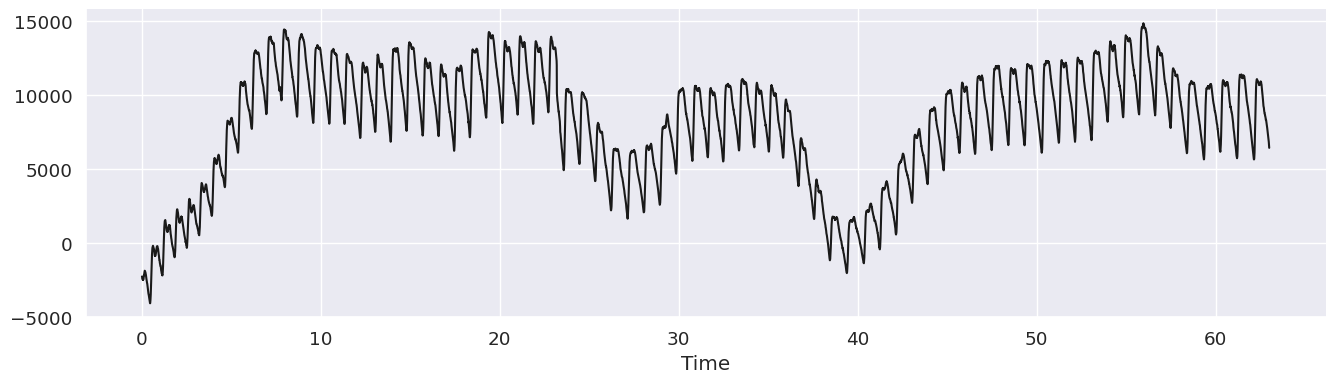

In [ ]:
sns.set(font_scale=1.2)

sf = 128.
time = np.arange(peripheral_data.shape[2]) / sf

fig, ax = plt.subplots(1, 1, figsize=(16, 4))
plt.plot(time,peripheral_data[25,6], lw=1.5, color='k')
plt.xlabel('Time')
# plt.ylabel('Voltage')
sns.despine()

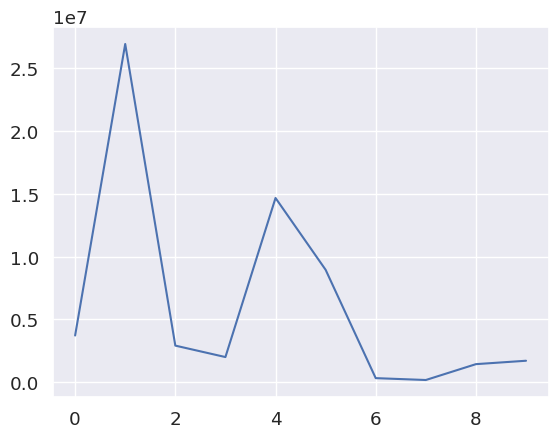

In [ ]:
# Define window length (4 seconds)
sf=128
win = 4 * sf
# freqs, psd = signal.welch(eeg_data[0,0], sf, nperseg=win)
freqs, psd = signal.welch(peripheral_data[0,6], sf, nperseg=win)

# Plot the power spectrum
# plt.plot(freqs, psd)
plt.plot(psd[0:10])


# New data reading

In [ ]:
!pip install git+https://github.com/forrestbao/pyeeg.git

  Cloning https://github.com/forrestbao/pyeeg.git to /tmp/pip-req-build-2gauznog
  Running command git clone --filter=blob:none --quiet https://github.com/forrestbao/pyeeg.git /tmp/pip-req-build-2gauznog
  Resolved https://github.com/forrestbao/pyeeg.git to commit a6c18bb093e4748f9d9c208535a6ae024a0802b8
  Preparing metadata (setup.py) ... done
  Created wheel for pyeeg: filename=pyeeg-0.4.4-py2.py3-none-any.whl size=28112 sha256=c5a9140f307d7f1438d78b375eedc070c9f550df85163fa787a06c483af0e027
  Stored in directory: /tmp/pip-ephem-wheel-cache-tt_rmwsl/wheels/a8/c4/1a/cee09dcc12a11620066d35ace42e3c1e3bfbcc1db3a0ce7788
Successfully built pyeeg


In [ ]:
import pyeeg as pe

In [ ]:
# channel   = [1,2,3,4,6,11,13,17,19,20,21,25,29,31]
channel     = [i for i in range(32)] #+ [38]
band        = [4,8,12,16,25,45]
window_size = 256
step_size   = 16
sample_rate = 128

In [ ]:
files = []
for n in range(1, 4):
    s = ''
    if n < 10:
        s += '0'
    s += str(n)
    files.append(s)
print(files)

# subjectList = ['01','02','03']
# subjectList = ['01']
subjectList = files

['01', '02', '03']


In [ ]:
def FFT_Processing(sub, channel, band, window_size, step_size, sample_rate):
    '''
    arguments:  string subject
                list channel indice
                list band
                int window size for FFT
                int step size for FFT
                int sample rate for FFT
    return:     void
    '''
    meta = []
    with open("/content/data_preprocessed_python/s" + sub + '.dat', 'rb') as file:

        subject = pickle.load(file, encoding='latin1') #resolve the python 2 data problem by encoding : latin1

        for i in range (0,40):
            # loop over 0-39 trails
            data = subject["data"][i]
            labels = subject["labels"][i]
            start = 0;

            while start + window_size < data.shape[1]:
                meta_array = []
                meta_data = []
                meta_data = [data[i][start : start + window_size] for i in channel]
                # print(np.array(meta_data))
                # for j in channel:
                #     X = data[j][start : start + window_size]
                #     Y = pe.bin_power(X, band, sample_rate)
                #     meta_data = meta_data + list(Y[0])

                meta_array.append(np.array(meta_data))
                meta_array.append(labels)

                meta.append(np.array(meta_array))
                start = start + step_size

        meta = np.array(meta)
        print(meta.shape)
        np.save('/content/temp/s' + sub, meta, allow_pickle=True, fix_imports=True)

In [ ]:
!rm -r /content/temp
!mkdir /content/temp

rm: cannot remove '/content/temp': No such file or directory


In [ ]:
for subjects in subjectList:
    FFT_Processing(subjects, channel, band, window_size, step_size, sample_rate)

<ipython-input-9-0e51a3fc1ec5>:35: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  meta.append(np.array(meta_array))


(19520, 2)
(19520, 2)
(19520, 2)


In [ ]:
data_training = []
label_training = []
data_testing = []
label_testing = []

for subjects in subjectList:

    with open('/content/temp/s' + subjects + '.npy', 'rb') as file:
      sub = np.load(file,allow_pickle=True)
      for i in range (0,sub.shape[0]):
        if i % 5 == 0:
          data_testing.append(sub[i][0])
          label_testing.append(sub[i][1])
        else:
          data_training.append(sub[i][0])
          label_training.append(sub[i][1])

data_training  = np.array(data_training)
label_training = np.array(label_training)
data_testing   = np.array(data_testing)
label_testing  = np.array(label_testing)


# np.save('/content/temp/data_training', data_training, allow_pickle=True, fix_imports=True)
# np.save('/content/temp/label_training', label_training, allow_pickle=True, fix_imports=True)
# print("training dataset:", data_training.shape, label_training.shape)

# np.save('/content/temp/data_testing', data_testing, allow_pickle=True, fix_imports=True)
# np.save('/content/temp/label_testing', label_testing, allow_pickle=True, fix_imports=True)
# print("testing dataset:", data_testing.shape, label_testing.shape)

In [ ]:
# data_training = data_training.reshape(data_training.shape[0],1,data_training.shape[1])
# data_testing = data_testing.reshape(data_testing.shape[0],1,data_testing.shape[1])

In [ ]:
print(data_training.shape)
print(label_training.shape)
print(data_testing.shape)
print(label_testing.shape)

(46848, 32, 256)
(46848, 4)
(11712, 32, 256)
(11712, 4)


In [ ]:
label_training


array([[7.71, 7.6 , 6.9 , 7.83],
       [7.71, 7.6 , 6.9 , 7.83],
       [7.71, 7.6 , 6.9 , 7.83],
       ...,
       [5.04, 5.01, 4.04, 4.96],
       [5.04, 5.01, 4.04, 4.96],
       [5.04, 5.01, 4.04, 4.96]])

# define dataset class

In [ ]:
thresh_valence = np.median(label_training[:,0])
thresh_arousal = np.median(label_training[:,1])
print(thresh_valence, thresh_arousal)

5.1 4.765000000000001


In [ ]:
count = [0,0,0,0,0]
shift = 2
for row in label_training:
    if np.sqrt((row[0] - thresh_valence)**2 + (row[1] - thresh_arousal)**2) < shift:
        count[0] += 1

    elif row[0] >= thresh_valence and row[1] >= thresh_arousal:
      count[1] += 1

    elif row[0] < thresh_valence and row[1] > thresh_arousal:
      count[2] += 1

    elif row[0] > thresh_valence and row[1] <= thresh_arousal:
      count[3] += 1

    elif row[0] <= thresh_valence and row[1] < thresh_arousal:
      count[4] += 1
    # else:
    #   print(row[0],row[1])
    #   count[0] += 1

print(count)

[9760, 11323, 7417, 9760, 8588]


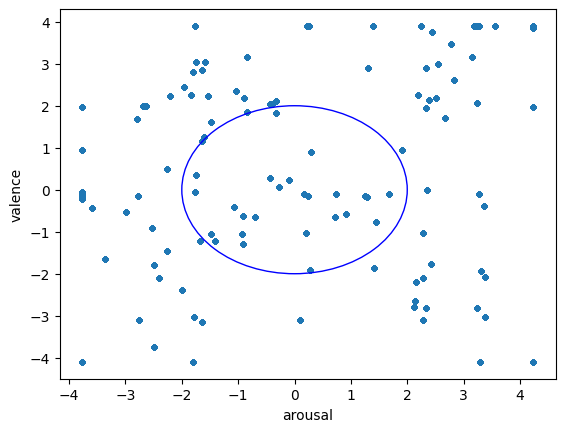

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(label_training[:,1]-thresh_arousal,label_training[:,0]-thresh_valence, s=10)

# Add labels and title
plt.xlabel('arousal')
plt.ylabel('valence')

circle = plt.Circle((0, 0), 2, color='blue', fill=False)
plt.gca().add_patch(circle)

plt.show()


In [ ]:
def normalize_rows(arr):
    means = np.mean(arr, axis=1)
    stds = np.std(arr, axis=1)
    normalized_arr = (arr - means[:, np.newaxis]) / stds[:, np.newaxis]
    # row_max = np.max(np.abs(data), axis=1, keepdims=True)
    # normalized_data = data / row_max
    return normalized_arr

# def normalize_rows(data):
#     row_max = np.max(data, axis=1, keepdims=True)
#     row_min = np.min(data, axis=1, keepdims=True)

#     normalized_data = (data - row_min) / (row_max - row_min)

#     return normalized_data


In [ ]:
from torchvision import transforms

# def dataset
'''
label: [happy, angry, relaxed, sad]
'''

class EEGDataset(Dataset):
  def __init__(self, data, labels, thresh_valence, thresh_arousal):
    self.data           = data
    self.labels         = labels
    self.thresh_valence = thresh_valence
    self.thresh_arousal = thresh_arousal

    self.transform = transforms.Compose([
                                transforms.ToTensor(),
                        ])

  def __getitem__(self, index):
    data = self.data[index]
    # print(data.shape)

    # normalize and transform
    data = normalize_rows(data)
    data = self.transform(data)

    label = self.labels[index]

    # if label[0] >= self.thresh_valence:
    #   return data, torch.tensor([1,0])
    # else:
    #   return data, torch.tensor([0,1])

    # if label[0] > self.thresh_valence and label[1] > self.thresh_arousal:
    #   return data, torch.tensor([1,0,0,0])

    # elif label[0] < self.thresh_valence and label[1] > self.thresh_arousal:
    #   return data, torch.tensor([0,1,0,0])

    # elif label[0] > self.thresh_valence and label[1] < self.thresh_arousal:
    #   return data, torch.tensor([0,0,1,0])

    # elif label[0] < self.thresh_valence and label[1] < self.thresh_arousal:
    #   return data, torch.tensor([0,0,0,1])
    # else:
    #   return data, torch.tensor([1,0,0,0])

    if np.sqrt((label[0] - self.thresh_valence)**2 + (label[1] - self.thresh_arousal)**2) < shift:
      return data, torch.tensor([1,0,0,0,0])

    elif label[0] >= self.thresh_valence and label[1] >= self.thresh_arousal:
      return data, torch.tensor([0,1,0,0,0])

    elif label[0] <= self.thresh_valence and label[1] >= self.thresh_arousal:
      return data, torch.tensor([0,0,1,0,0])

    elif label[0] >= self.thresh_valence and label[1] <= self.thresh_arousal:
      return data, torch.tensor([0,0,0,1,0])

    elif label[0] <= self.thresh_valence and label[1] <= self.thresh_arousal:
      return data, torch.tensor([0,0,0,0,1])



  def __len__(self):
    return len(self.data)


In [ ]:
train_eeg_dataset = EEGDataset(data_training, label_training, thresh_valence, thresh_arousal)
test_eeg_dataset  = EEGDataset(data_testing, label_testing, thresh_valence, thresh_arousal)

print(len(train_eeg_dataset))
d, l = train_eeg_dataset[500]
print(d.shape)
print(l)

46848
torch.Size([1, 32, 256])
tensor([0, 1, 0, 0, 0])


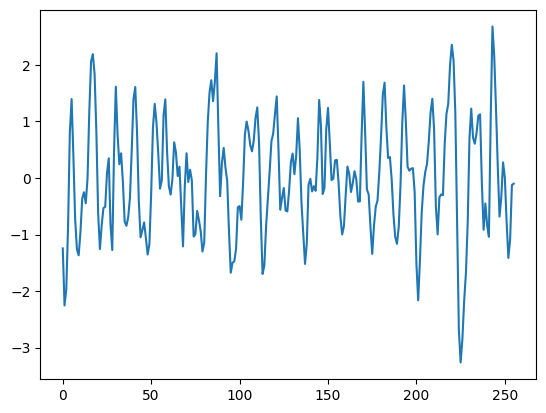

In [ ]:
plt.plot(d[0][0].detach().numpy())

In [ ]:
train_eeg_dataloader = DataLoader(train_eeg_dataset,batch_size= 256,shuffle=True, num_workers=2)
test_eeg_dataloader = DataLoader(test_eeg_dataset,batch_size= 256, shuffle=False, num_workers=2)

# Model and Training

In [ ]:
# define loss function and optimizer
import torch
import torch.nn as nn

class Cnn1dModel(nn.Module):
    def __init__(self, num_classes):
        super(Cnn1dModel, self).__init__()

        # Define the 1D convolutional layers
        self.convs = nn.Sequential(

            nn.Conv1d(32, 512, kernel_size=50, stride=1, padding='same'),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Dropout(p=0.3),

            nn.Conv1d(512, 256, kernel_size=25, stride=1, padding='same'),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Dropout(p=0.3),

        )

        self.lstm1 = nn.LSTM(input_size=256,hidden_size=256,batch_first=True)
        self.h_sig_1 = nn.Hardsigmoid()
        self.lstm2 = nn.LSTM(input_size=256,hidden_size=128,batch_first=True)
        self.h_sig_2 = nn.Hardsigmoid()


        # Calculate the input size to the fully connected layer
        self.fc_input_size = 64*128

        # Define the fully connected layers
        self.linears = nn.Sequential(
          nn.Linear(self.fc_input_size, 256),
          nn.ReLU(),
          nn.Linear(256, 128),
          nn.ReLU(),
          nn.Linear(128, 64),
          nn.ReLU(),
          nn.Linear(64, num_classes),
          nn.Softmax(dim=1)

        )

    def forward(self, x):
        x = self.convs(x)
        # print('After Conv: ', x.shape)

        x = x.permute(0, 2, 1)
        # print('After reshaping: ', x.shape)

        x,_ = self.lstm1(x)
        # x = self.h_sig_1(x)
        x,_ = self.lstm2(x)
        # x = self.h_sig_2(x)
        # print('After lstm: ', x.shape)

        x = x.reshape(x.shape[0],self.fc_input_size)
        # print('After flatten: ', x.shape)

        x = self.linears(x)

        # return x
        return x

# Instantiate the model
model = Cnn1dModel(num_classes=4)

# Print the model architecture
print(model)

Cnn1dModel(
  (convs): Sequential(
    (0): Conv1d(32, 512, kernel_size=(50,), stride=(1,), padding=same)
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.3, inplace=False)
    (4): Conv1d(512, 256, kernel_size=(25,), stride=(1,), padding=same)
    (5): ReLU()
    (6): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.3, inplace=False)
  )
  (lstm1): LSTM(256, 256, batch_first=True)
  (h_sig_1): Hardsigmoid()
  (lstm2): LSTM(256, 128, batch_first=True)
  (h_sig_2): Hardsigmoid()
  (linears): Sequential(
    (0): Linear(in_features=8192, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=4, bias=True)
    (7): Softmax(dim=1)
  )
)


In [ ]:
# Test sample
model.to(device)
id = 3
data_p, label_p = test_eeg_dataset[id]
data_p = data_p.to(device)
data_p = data_p.to(torch.float)

yhat = model.forward(data_p.to(device)).float() # Find predicted
label_p= label_p.float().to(device)                   # label to device

print(label_p)
print(yhat)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:309: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:1003.)
  return F.conv1d(input, weight, bias, self.stride,


tensor([0., 1., 0., 0., 0.], device='cuda:0')
tensor([[0.2490, 0.2490, 0.2399, 0.2621]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)


In [ ]:
model = Cnn1dModel(num_classes=5)

EPOCHS  = 200
results = {'loss': [], 'val_loss': [], 'auc': [], 'val_auc': []}
optim   = torch.optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-3)
loss    = nn.CrossEntropyLoss()


In [ ]:
EPOCHS  = 100

In [ ]:
model.to(device)
total_data = len(train_eeg_dataloader)
for epoch in range(EPOCHS):
    # ------training------
    epoch_losses = []
    epoch_aucs = []
    model.train()
    for idx, (x, y) in enumerate(train_eeg_dataloader):
        x    = x.squeeze(1).to(torch.float)
        yhat = model.forward(x.to(device)).float()    # Find predicted
        y    = y.float().to(device)                   # label to device
        out  = loss(yhat, y)                          # find loss between predicted and label

        # accuracy
        labels  = torch.argmax(y,dim=1)
        pred    = torch.argmax(yhat,dim=1)
        correct = (labels == pred).sum().item()
        epoch_aucs.append(correct)


        # Backpropagation step
        optim.zero_grad()
        out.backward()
        optim.step()

        epoch_losses.append(out.item())

        if (idx+1) % 20 == 0:
          print("Epoch: {}/{}\t batch: {}/{}\tTrain Loss: {:.4f}\t".format(epoch+1, EPOCHS, idx+1, total_data,out.item()) )


    epoch_loss = np.mean(epoch_losses)
    epoch_auc = np.sum(epoch_aucs) / len(train_eeg_dataset)

    # -----validation-----
    model.eval()
    epoch_val_losses = []
    epoch_val_aucs = []
    with torch.no_grad():
        for x, y in test_eeg_dataloader:
            x    = x.squeeze(1)
            x    = x.to(torch.float)
            yhat = model.forward(x.to(device)).float() # Find predicted
            y    = y.float().to(device)                   # label to device
            out  = loss(yhat, y)
            epoch_val_losses.append(out.item())

            # accuracy
            gt      = torch.argmax(y,dim=1)
            pred    = torch.argmax(yhat,dim=1)
            correct = (gt == pred).sum().item()
            epoch_val_aucs.append(correct)


    epoch_val_loss = np.mean(epoch_val_losses)
    epoch_val_auc  = np.sum(epoch_val_aucs) / len(test_eeg_dataset)


    # populate results
    results['loss'].append( epoch_loss )
    results['val_loss'].append( epoch_val_loss )
    results['auc'].append( epoch_auc )
    results['val_auc'].append( epoch_val_auc )

    print("\nEpoch {}/{}\tTrain Loss: {:.4f}\tTest Loss: {:.4f}\tTrain Acc: {:.4f}\tTest Acc: {:.4f}\n".format(
          epoch+1, EPOCHS, epoch_loss, epoch_val_loss, epoch_auc, epoch_val_auc) )


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:309: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:1003.)
  return F.conv1d(input, weight, bias, self.stride,


Epoch: 1/200	 batch: 20/183	Train Loss: 1.0212	
Epoch: 1/200	 batch: 40/183	Train Loss: 0.9966	
Epoch: 1/200	 batch: 60/183	Train Loss: 1.0038	
Epoch: 1/200	 batch: 80/183	Train Loss: 1.0216	
Epoch: 1/200	 batch: 100/183	Train Loss: 1.0043	
Epoch: 1/200	 batch: 120/183	Train Loss: 1.0358	
Epoch: 1/200	 batch: 140/183	Train Loss: 0.9973	
Epoch: 1/200	 batch: 160/183	Train Loss: 1.0162	
Epoch: 1/200	 batch: 180/183	Train Loss: 0.9843	

Epoch 1/200	Train Loss: 1.0260	Test Loss: 1.0080	Train Acc: 0.8796	Test Acc: 0.8962

Epoch: 2/200	 batch: 20/183	Train Loss: 1.0558	
Epoch: 2/200	 batch: 40/183	Train Loss: 1.0351	
Epoch: 2/200	 batch: 60/183	Train Loss: 1.0066	
Epoch: 2/200	 batch: 80/183	Train Loss: 1.0439	
Epoch: 2/200	 batch: 100/183	Train Loss: 1.0254	
Epoch: 2/200	 batch: 120/183	Train Loss: 0.9698	
Epoch: 2/200	 batch: 140/183	Train Loss: 1.0546	
Epoch: 2/200	 batch: 160/183	Train Loss: 1.0163	
Epoch: 2/200	 batch: 180/183	Train Loss: 1.0441	

Epoch 2/200	Train Loss: 1.0231	Test Los

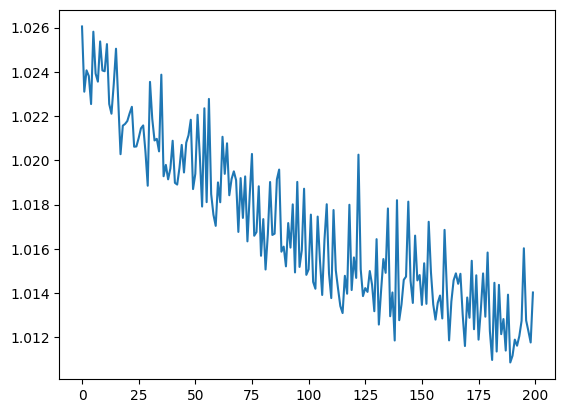

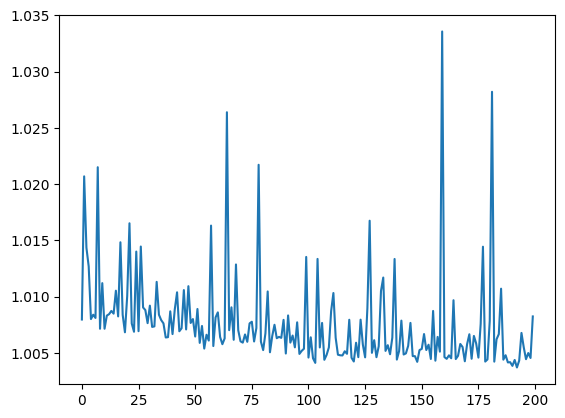

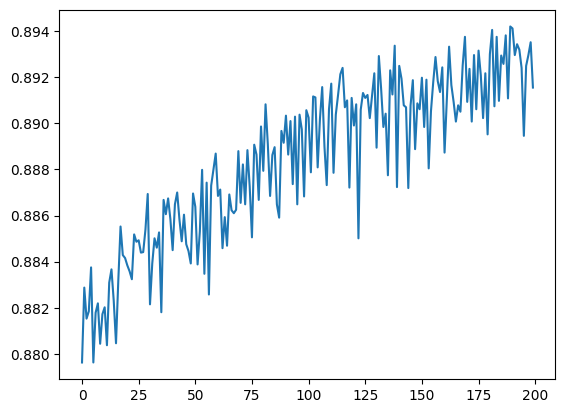

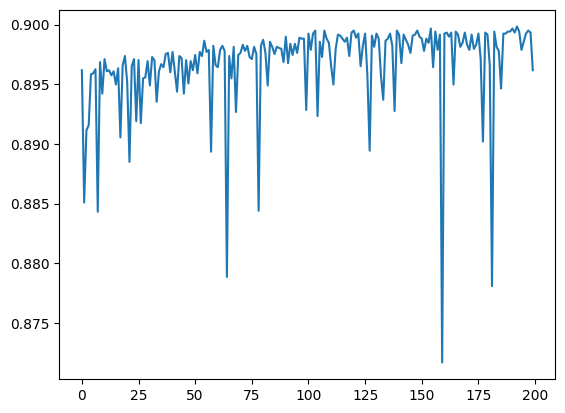

In [ ]:
import matplotlib.pyplot as plt
# results = {'loss': [], 'val_loss': [], 'auc': [], 'val_auc': []}

plt.plot(results['loss'])
plt.show()

plt.plot(results['val_loss'])
plt.show()

plt.plot(results['auc'])
plt.show()

plt.plot(results['val_auc'])
plt.show()

In [ ]:
import matplotlib.pyplot as plt
# results = {'loss': [], 'val_loss': [], 'auc': [], 'val_auc': []}

plt.plot(results['loss'])
plt.show()

plt.plot(results['val_loss'])
plt.show()

plt.plot(results['auc'])
plt.show()

plt.plot(results['val_auc'])
plt.show()

In [ ]:
# With PPG 400 cnn_lstm_eeg_400
# Without PPG 600 cnn_lstm_eeg_withoutPPG_600

In [ ]:
# Save only the model's state dictionary
# torch.save(model.state_dict(), '/content/drive/MyDrive/models/eeg_emotion/cnn_lstm_eeg_withoutPPG_600.pth')
model.load_state_dict(torch.load('/content/drive/MyDrive/models/eeg_emotion/cnn_lstm_eeg_withoutPPG_600.pth'))
model.to(device)

Cnn1dModel(
  (convs): Sequential(
    (0): Conv1d(32, 512, kernel_size=(50,), stride=(1,), padding=same)
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.3, inplace=False)
    (4): Conv1d(512, 256, kernel_size=(25,), stride=(1,), padding=same)
    (5): ReLU()
    (6): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.3, inplace=False)
  )
  (lstm1): LSTM(256, 256, batch_first=True)
  (h_sig_1): Hardsigmoid()
  (lstm2): LSTM(256, 128, batch_first=True)
  (h_sig_2): Hardsigmoid()
  (linears): Sequential(
    (0): Linear(in_features=8192, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=5, bias=True)
    (7): Softmax(dim=1)
  )
)

In [ ]:
# Test sample
id = 100
data_p, label_p = test_eeg_dataset[id]
data_p = data_p.to(device)
data_p = data_p.to(torch.float)

yhat = model.forward(data_p.to(device)).float() # Find predicted
label_p= label_p.float().to(device)                   # label to device

print(label_p)
print(yhat)

tensor([0., 1., 0., 0., 0.], device='cuda:0')
tensor([[1.7685e-14, 9.9966e-01, 1.6024e-16, 9.3096e-16, 3.4143e-04]],
       device='cuda:0', grad_fn=<SoftmaxBackward0>)


In [ ]:
model.eval()
epoch_val_losses = []
epoch_val_aucs = []
with torch.no_grad():
    for x, y in test_eeg_dataloader:
        x    = x.squeeze(1)
        x    = x.to(torch.float)
        yhat = model.forward(x.to(device)).float() # Find predicted
        y    = y.float().to(device)                   # label to device

        # accuracy
        gt      = torch.argmax(y,dim=1)
        pred    = torch.argmax(yhat,dim=1)
        correct = (gt == pred).sum().item()
        epoch_val_aucs.append(correct)


epoch_val_auc  = np.sum(epoch_val_aucs) / len(test_eeg_dataset)
print('Accuracy: ', epoch_val_auc)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:309: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:1003.)
  return F.conv1d(input, weight, bias, self.stride,


Accuracy:  0.8961748633879781
